In [2]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
region = [0, 100e3, 0, 90e3]
coordinates = vd.scatter_points(region, size=2000, extra_coords=2000, random_state=1)
inclination, declination = -20, -15
base_level = 500
noise_level = 200
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

def magnetic(coordinates):
    dipole_coordinates = (60e3, 60e3, -2e3)
    magnetic_field = hm.dipole_magnetic(
        coordinates,
        dipoles=dipole_coordinates,
        magnetic_moments=hm.magnetic_angles_to_vec(4e13, inclination, declination),
        field="b",
    )
    magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))
    
    dipole2_coordinates = (20e3, 80e3, -4e3)
    magnetic_field = hm.dipole_magnetic(
        coordinates,
        dipoles=dipole2_coordinates,
        magnetic_moments=hm.magnetic_angles_to_vec(1.5e14, inclination, declination),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Pipe
    size = 90
    pipe_coordinates = (60e3, 80e3, -2e3)
    magnetic_field = hm.prism_magnetic(
        coordinates,
        prisms=[
            pipe_coordinates[0] - size,
            pipe_coordinates[0] + size,
            pipe_coordinates[1] - size,
            pipe_coordinates[1] + size,
            pipe_coordinates[2] - 10e3,
            pipe_coordinates[2],
        ],
        magnetization=hm.magnetic_angles_to_vec(3e5, -90, 0),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Dike
    dike_coordinates = (30e3, 30e3, 0)
    magnetic_field = hm.prism_magnetic(
        coordinates,
        prisms=[
            dike_coordinates[0] - 100e3,
            dike_coordinates[0] + 100e3,
            dike_coordinates[1] - 1000,
            dike_coordinates[1] + 1000,
            dike_coordinates[2] - 2000,
            dike_coordinates[2],
        ],
        magnetization=hm.magnetic_angles_to_vec(1e3, inclination, declination),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Line
    line_coordinates = [30e3, 50e3, -1e3]
    magnetic_field = hm.prism_magnetic(
        coordinates,
        prisms=[
            line_coordinates[0] - 50,
            line_coordinates[0] + 50,
            line_coordinates[1],
            line_coordinates[1] + 100e3,
            line_coordinates[2] - 500,
            line_coordinates[2] + 500,
        ],
        magnetization=hm.magnetic_angles_to_vec(1e5, inclination, declination),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Sill
    sill_coordinates = [80e3, 25e3, -0.5e3]
    magnetic_field = hm.prism_magnetic(
        coordinates,
        prisms=[
            sill_coordinates[0] - 20e3,
            sill_coordinates[0] + 20e3,
            sill_coordinates[1] - 20e3,
            sill_coordinates[1] + 20e3,
            sill_coordinates[2] - 150,
            sill_coordinates[2] + 150,
        ],
        magnetization=hm.magnetic_angles_to_vec(2e3, inclination, declination),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Regional
    magnetic_anomaly += 0.01 * coordinates[0] - 0.02 * coordinates[1]
    
    # Add noise and the base level
    magnetic_anomaly += np.random.default_rng(42).normal(
        0, noise_level, size=magnetic_anomaly.shape
    )
    magnetic_anomaly += base_level
    return(magnetic_anomaly)

magnetic_anomaly = magnetic(coordinates)

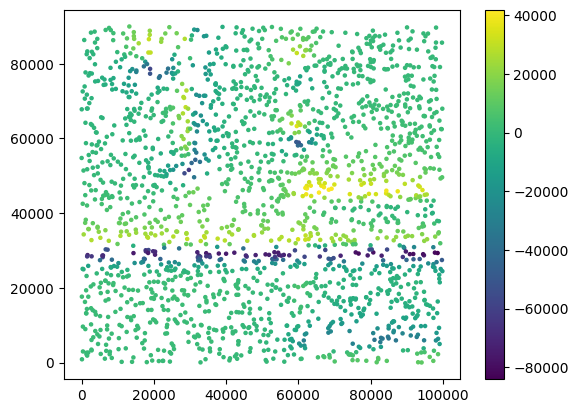

In [5]:
plt.scatter(coordinates[0], coordinates[1], s=5, c=magnetic_anomaly)
plt.colorbar()

In [6]:
# Equivalent sources

fonts = hm.EquivalentSourcesGB(damping=1,depth=1e3)
fonts.fit([coordinates[0],coordinates[1],coordinates[2]],data=magnetic_anomaly)

EquivalentSourcesGB(damping=1, depth=1000.0)

Text(0.5, 1.0, 'Equivalent sources')

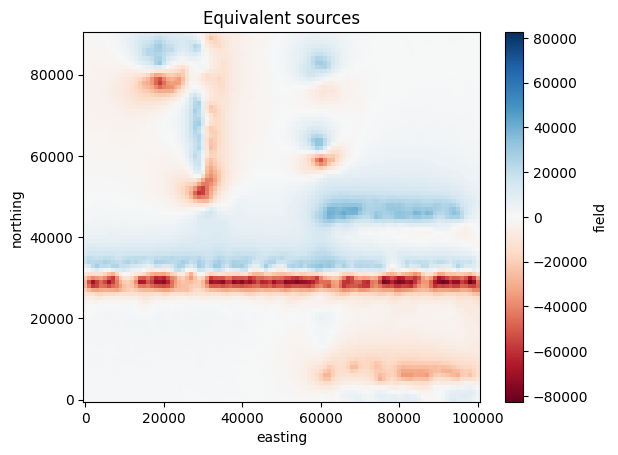

In [25]:
# Gridding equivalent sources

grid_coords_eq = vd.grid_coordinates(region,spacing=1e3,extra_coords=2e3)
grid_eq = fonts.grid(grid_coords_eq,data_names="field")

escala = vd.maxabs(grid_eq.field)
grid_eq.field.plot(cmap="RdBu",vmin=-escala,vmax=escala)
#grid_eq.field.plot()
plt.title("Equivalent sources")

Text(0.5, 1.0, 'Regular grid')

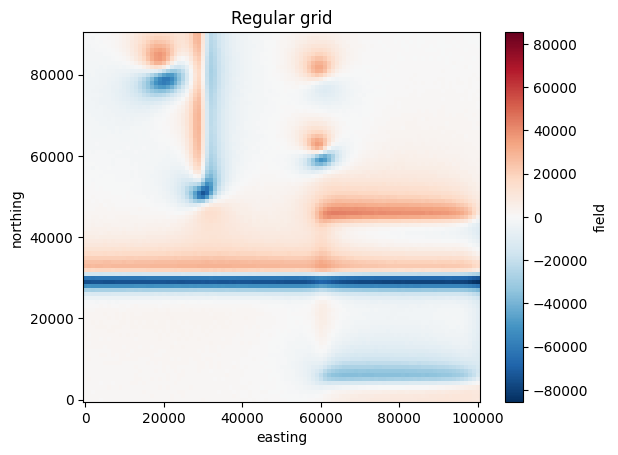

In [17]:
# # Regular grid

coordinates_grid = vd.grid_coordinates(region, spacing=1000, extra_coords=2000)

magnetic_anomaly_grid = magnetic(coordinates_grid)

grid_true = vd.make_xarray_grid(
    coordinates_grid[:2], (magnetic_anomaly_grid, coordinates_grid[-1]), data_names=["field", "height"]
)
grid_true.field.plot()
plt.title("Regular grid")

-28119.350217345025
54879.21141425221
165.58042612866123
__
-85477.72554894247
43673.85597633254
-1158.9731958113073


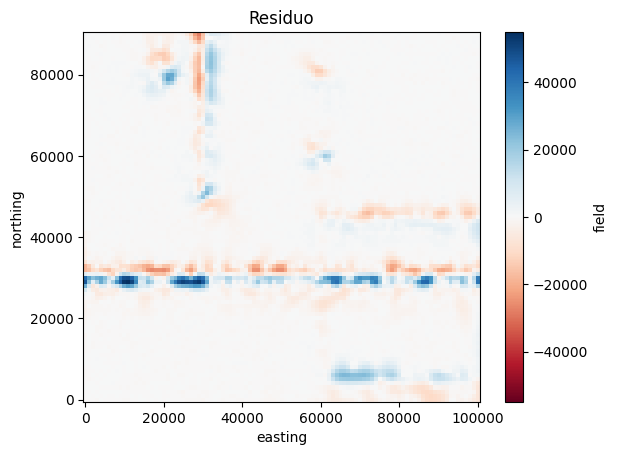

In [27]:
residuo = grid_eq - grid_true

#residuo.field.plot()

escala = vd.maxabs(residuo.field)
residuo.field.plot(cmap="RdBu",vmin=-escala,vmax=escala)
plt.title("Residuo")
print(np.min(residuo.field.values))
print(np.max(residuo.field.values))
print(np.mean(residuo.field.values))
print("__")
print(np.min(grid_true.field.values))
print(np.max(grid_true.field.values))
print(np.mean(grid_true.field.values))

In [28]:
media = np.sum(grid_eq.field.values)/np.size(grid_eq.field)
residuo_2 = np.sum(residuo.field.values**2)
R_2_true = 1 - (residuo_2/np.sum((grid_eq.field.values - media)**2))
R_2_true

0.8639119284374848

In [29]:
sq_exp = np.sum((grid_true.field.values - media)**2) 
R_2_sq = np.sum((grid_true.field.values - media)**2) / np.sum((grid_eq.field.values - media)**2)
R_2_sq

1.4261437474445895

In [12]:
# Random cross-validation 

R_2_random = np.mean(vd.cross_val_score(fonts,coordinates,magnetic_anomaly))
R_2_random

0.8929151146601543

In [13]:
# Blocked cross-validation

block = np.arange(1000,10950,950) 
nsplits = 5
R_2_block = [] 

for spacing in block:
    R_2_block.append(np.mean(
        vd.cross_val_score(
            fonts,
            coordinates,
            magnetic_anomaly,
            cv=vd.BlockKFold(spacing=spacing, n_splits=nsplits, shuffle=True, random_state=123),
        )
    ))

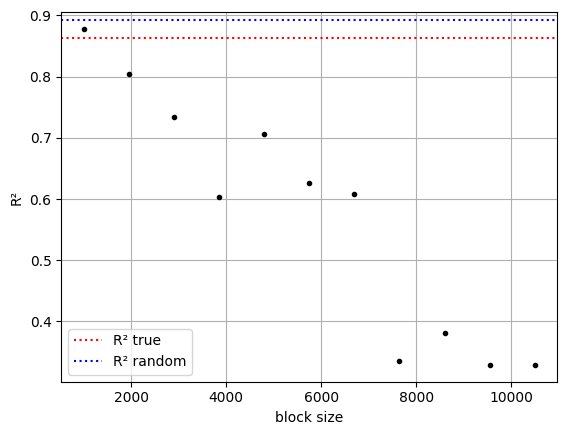

In [15]:
plt.plot(block,R_2_block,".k")
plt.xlabel("block size")
plt.ylabel("R²")
plt.axhline(y = R_2_true, color = 'red', linestyle = 'dotted', label="R² true") 
plt.axhline(y = R_2_random, color = 'blue', linestyle = 'dotted', label="R² random") 
plt.grid(True)
plt.legend()